# Analysis for Credit card Sales 

In [26]:
%load_ext autoreload
%autoreload 2
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Preprocessing steps

In [27]:
# Check current working directory
print("Current working directory:", os.getcwd())
print("Contents of current directory:", os.listdir("."))
excel_path = os.path.join("..", "data", "raw", "DataScientist_CaseStudy_Dataset.xlsx")
xls = pd.ExcelFile(excel_path)
datasets = {
    sheet: pd.read_excel(xls, sheet_name=sheet, engine="openpyxl")
    for sheet in xls.sheet_names
}
print("All sheet names:", list(datasets.keys()))
print("Available datasets:", datasets.keys())
raw_datasets = datasets.pop("Description")
# check the length of each dataset
for name, df in datasets.items():
    print(f"{name}: {len(df)} rows, {len(df.columns)} columns")

Current working directory: /home/c-hiy/direct-marketing-optimization/notebooks
Contents of current directory: ['cc_analysis.ipynb', 'mf_analysis.ipynb', 'general_analysis.ipynb', 'cl_analysis.ipynb']
All sheet names: ['Description', 'Soc_Dem', 'Products_ActBalance', 'Inflow_Outflow', 'Sales_Revenues']
Available datasets: dict_keys(['Description', 'Soc_Dem', 'Products_ActBalance', 'Inflow_Outflow', 'Sales_Revenues'])
Soc_Dem: 1615 rows, 4 columns
Products_ActBalance: 1615 rows, 13 columns
Inflow_Outflow: 1587 rows, 15 columns
Sales_Revenues: 969 rows, 7 columns


In [28]:
for df in datasets.values():
    pd.set_option("display.max_columns", None)  # Show all columns
    print(df.columns.tolist())

['Client', 'Sex', 'Age', 'Tenure']
['Client', 'Count_CA', 'Count_SA', 'Count_MF', 'Count_OVD', 'Count_CC', 'Count_CL', 'ActBal_CA', 'ActBal_SA', 'ActBal_MF', 'ActBal_OVD', 'ActBal_CC', 'ActBal_CL']
['Client', 'VolumeCred', 'VolumeCred_CA', 'TransactionsCred', 'TransactionsCred_CA', 'VolumeDeb', 'VolumeDeb_CA', 'VolumeDebCash_Card', 'VolumeDebCashless_Card', 'VolumeDeb_PaymentOrder', 'TransactionsDeb', 'TransactionsDeb_CA', 'TransactionsDebCash_Card', 'TransactionsDebCashless_Card', 'TransactionsDeb_PaymentOrder']
['Client', 'Sale_MF', 'Sale_CC', 'Sale_CL', 'Revenue_MF', 'Revenue_CC', 'Revenue_CL']


In [29]:
# Get clients from Sales_Revenues dataset
sales_clients = set(datasets["Sales_Revenues"]["Client"].unique())
print(f"Clients in Sales_Revenues: {len(sales_clients)}")

# Create train and test datasets
datasets_train = {}
datasets_test = {}

for name, df in datasets.items():
    if "Client" in df.columns:
        # Train: clients that exist in Sales_Revenues
        train_mask = df["Client"].isin(sales_clients)
        train_df = df[train_mask].copy()

        # Test: clients that do NOT exist in Sales_Revenues
        test_df = df[~train_mask].copy()

        # Store with new names
        datasets_train[f"{name}_train"] = train_df
        datasets_test[f"{name}_test"] = test_df

        print(f"{name}:")
        print(f"  Total rows: {len(df)}")
        print(f"  Train rows: {len(train_df)} ({len(train_df)/len(df)*100:.1f}%)")
        print(f"  Test rows: {len(test_df)} ({len(test_df)/len(df)*100:.1f}%)")
        print(f"  Train unique clients: {train_df['Client'].nunique()}")
        print(f"  Test unique clients: {test_df['Client'].nunique()}")
        print()

# Summary
print("=== TRAIN DATASETS ===")
for name, df in datasets_train.items():
    print(f"{name}: {len(df)} rows, {df['Client'].nunique()} unique clients")

print("\n=== TEST DATASETS ===")
for name, df in datasets_test.items():
    print(f"{name}: {len(df)} rows, {df['Client'].nunique()} unique clients")

# Verification
print(f"\n=== VERIFICATION ===")
print(f"Sales_Revenues clients: {len(sales_clients)}")
print(
    f"Sales_Revenues_train clients: {datasets_train['Sales_Revenues_train']['Client'].nunique()}"
)
print(
    f"Sales_Revenues_test clients: {datasets_test['Sales_Revenues_test']['Client'].nunique()}"
)
print(
    f"Should be equal: {len(sales_clients) == datasets_train['Sales_Revenues_train']['Client'].nunique()}"
)
print(
    f"Test should be 0: {datasets_test['Sales_Revenues_test']['Client'].nunique() == 0}"
)

Clients in Sales_Revenues: 969
Soc_Dem:
  Total rows: 1615
  Train rows: 969 (60.0%)
  Test rows: 646 (40.0%)
  Train unique clients: 969
  Test unique clients: 646

Products_ActBalance:
  Total rows: 1615
  Train rows: 969 (60.0%)
  Test rows: 646 (40.0%)
  Train unique clients: 969
  Test unique clients: 646

Inflow_Outflow:
  Total rows: 1587
  Train rows: 951 (59.9%)
  Test rows: 636 (40.1%)
  Train unique clients: 951
  Test unique clients: 636

Sales_Revenues:
  Total rows: 969
  Train rows: 969 (100.0%)
  Test rows: 0 (0.0%)
  Train unique clients: 969
  Test unique clients: 0

=== TRAIN DATASETS ===
Soc_Dem_train: 969 rows, 969 unique clients
Products_ActBalance_train: 969 rows, 969 unique clients
Inflow_Outflow_train: 951 rows, 951 unique clients
Sales_Revenues_train: 969 rows, 969 unique clients

=== TEST DATASETS ===
Soc_Dem_test: 646 rows, 646 unique clients
Products_ActBalance_test: 646 rows, 646 unique clients
Inflow_Outflow_test: 636 rows, 636 unique clients
Sales_Revenu

In [ ]:
# keep only Revenue_CL and Sale_CL
datasets_train["Sales_Revenues_train"] = datasets_train["Sales_Revenues_train"][
    ["Client", "Revenue_CL", "Sale_CL"]
]

In [31]:
def merge_all_training_data(
    datasets_dict,
    base_dataset_key="Sales_Revenues_train",
    datasets_to_merge=None,
    join_key="Client",
):
    """
    Merge all training datasets on a specified key for comprehensive analysis

    Parameters:
    -----------
    datasets_dict : dict
        Dictionary containing all datasets to merge
    base_dataset_key : str
        Key for the base dataset (default: 'Sales_Revenues_train')
    datasets_to_merge : list, optional
        List of dataset keys to merge. If None, merges all except base
    join_key : str
        Column name to join on (default: 'Client')

    Returns:
    --------
    pandas.DataFrame
        Merged dataset
    """

    print("=== MERGING ALL TRAINING DATASETS ===")

    # Validate base dataset exists
    if base_dataset_key not in datasets_dict:
        raise ValueError(f"Base dataset '{base_dataset_key}' not found in datasets")

    # Start with base dataset
    merged_df = datasets_dict[base_dataset_key].copy()
    print(f"Base dataset ({base_dataset_key}): {merged_df.shape}")

    # Determine datasets to merge
    if datasets_to_merge is None:
        datasets_to_merge = [
            key for key in datasets_dict.keys() if key != base_dataset_key
        ]

    # Validate join key exists in base dataset
    if join_key not in merged_df.columns:
        raise ValueError(f"Join key '{join_key}' not found in base dataset")

    # Merge each dataset
    for dataset_name in datasets_to_merge:
        if dataset_name in datasets_dict:
            df_to_merge = datasets_dict[dataset_name]
            print(f"\nMerging {dataset_name}: {df_to_merge.shape}")

            # Check for join key column
            if join_key in df_to_merge.columns:
                # Merge on join key
                before_shape = merged_df.shape
                merged_df = merged_df.merge(
                    df_to_merge, on=join_key, how="left", suffixes=("", "_dup")
                )
                after_shape = merged_df.shape

                print(f"  Before merge: {before_shape}")
                print(f"  After merge: {after_shape}")
                print(f"  Records with {join_key}: {merged_df[join_key].nunique()}")

                # Check for duplicate columns and handle them
                duplicate_cols = [
                    col for col in merged_df.columns if col.endswith("_dup")
                ]
                if duplicate_cols:
                    print(
                        f"  ⚠️  Duplicate columns found: {[col.replace('_dup', '') for col in duplicate_cols]}"
                    )
                    # Drop duplicate columns
                    merged_df = merged_df.drop(columns=duplicate_cols)
                    print(f"  ✅ Dropped duplicate columns")

            else:
                print(f"  ⚠️  No '{join_key}' column found in {dataset_name}")
        else:
            print(f"  ⚠️  {dataset_name} not found in datasets")

    print(f"\n=== FINAL MERGED DATASET ===")
    print(f"Shape: {merged_df.shape}")
    print(f"Unique {join_key}s: {merged_df[join_key].nunique()}")
    print(f"Columns: {len(merged_df.columns)}")

    return merged_df


def analyze_data_quality(df, show_columns=True, max_missing_display=20):
    """
    Analyze data quality of a dataset

    Parameters:
    -----------
    df : pandas.DataFrame
        Dataset to analyze
    show_columns : bool
        Whether to display all column names
    max_missing_display : int
        Maximum number of missing value columns to display
    """

    print(f"=== DATA QUALITY CHECK ===")
    print(f"Dataset shape: {df.shape}")

    # Display column names if requested
    if show_columns:
        print(f"\nColumn names:")
        for i, col in enumerate(df.columns, 1):
            print(f"{i:2d}. {col}")

    # Check for missing values
    print(f"\nMissing values per column:")
    missing_data = df.isnull().sum()
    missing_data = missing_data[missing_data > 0].sort_values(ascending=False)

    if len(missing_data) > 0:
        print(f"Found {len(missing_data)} columns with missing values:")
        display_missing = missing_data.head(max_missing_display)
        for col, count in display_missing.items():
            percentage = (count / len(df)) * 100
            print(f"  {col}: {count} ({percentage:.1f}%)")

        if len(missing_data) > max_missing_display:
            print(f"  ... and {len(missing_data) - max_missing_display} more columns")
    else:
        print("No missing values found! ✅")

    # Check data types
    print(f"\nData types summary:")
    dtype_summary = df.dtypes.value_counts()
    for dtype, count in dtype_summary.items():
        print(f"  {dtype}: {count} columns")

    # Check for potential issues
    print(f"\nPotential issues:")

    # Check for duplicate rows
    duplicates = df.duplicated().sum()
    if duplicates > 0:
        print(f"  ⚠️  {duplicates} duplicate rows found")
    else:
        print(f"  ✅ No duplicate rows")

    # Check for constant columns
    constant_cols = []
    for col in df.columns:
        if df[col].nunique() <= 1:
            constant_cols.append(col)

    if constant_cols:
        print(f"  ⚠️  Constant columns (nunique ≤ 1): {constant_cols}")
    else:
        print(f"  ✅ No constant columns")


# Reusable function call with parameters
combined_train_data = merge_all_training_data(
    datasets_dict=datasets_train,
    base_dataset_key="Sales_Revenues_train",
    join_key="Client",
)

# Analyze data quality
analyze_data_quality(combined_train_data, show_columns=True)

=== MERGING ALL TRAINING DATASETS ===
Base dataset (Sales_Revenues_train): (969, 3)

Merging Soc_Dem_train: (969, 4)
  Before merge: (969, 3)
  After merge: (969, 6)
  Records with Client: 969

Merging Products_ActBalance_train: (969, 13)
  Before merge: (969, 6)
  After merge: (969, 18)
  Records with Client: 969

Merging Inflow_Outflow_train: (951, 15)
  Before merge: (969, 18)
  After merge: (969, 32)
  Records with Client: 969

=== FINAL MERGED DATASET ===
Shape: (969, 32)
Unique Clients: 969
Columns: 32
=== DATA QUALITY CHECK ===
Dataset shape: (969, 32)

Column names:
 1. Client
 2. Revenue_CC
 3. Sale_CC
 4. Sex
 5. Age
 6. Tenure
 7. Count_CA
 8. Count_SA
 9. Count_MF
10. Count_OVD
11. Count_CC
12. Count_CL
13. ActBal_CA
14. ActBal_SA
15. ActBal_MF
16. ActBal_OVD
17. ActBal_CC
18. ActBal_CL
19. VolumeCred
20. VolumeCred_CA
21. TransactionsCred
22. TransactionsCred_CA
23. VolumeDeb
24. VolumeDeb_CA
25. VolumeDebCash_Card
26. VolumeDebCashless_Card
27. VolumeDeb_PaymentOrder
28. 

In [ ]:
numeric_features = [
    "Age",
    "Tenure",
    "Count_CA",
    "Count_SA",
    "Count_MF",
    "Count_OVD",
    "Count_CC",
    "Count_CL",
    "ActBal_CA",
    "ActBal_SA",
    "ActBal_MF",
    "ActBal_OVD",
    "ActBal_CC",
    "ActBal_CL",
    "VolumeCred",
    "VolumeCred_CA",
    "TransactionsCred",
    "TransactionsCred_CA",
    "VolumeDeb",
    "VolumeDeb_CA",
    "VolumeDebCash_Card",
    "VolumeDebCashless_Card",
    "VolumeDeb_PaymentOrder",
    "TransactionsDeb",
    "TransactionsDeb_CA",
    "TransactionsDebCash_Card",
    "TransactionsDebCashless_Card",
    "TransactionsDeb_PaymentOrder",
]
categorical_features = ["Sex"]

In [33]:
# fill missing numeric values with 0
combined_train_data[numeric_features] = combined_train_data[numeric_features].fillna(0)

# fill the missing categorical values with 'missing'
combined_train_data[categorical_features] = combined_train_data[
    categorical_features
].fillna("missing")

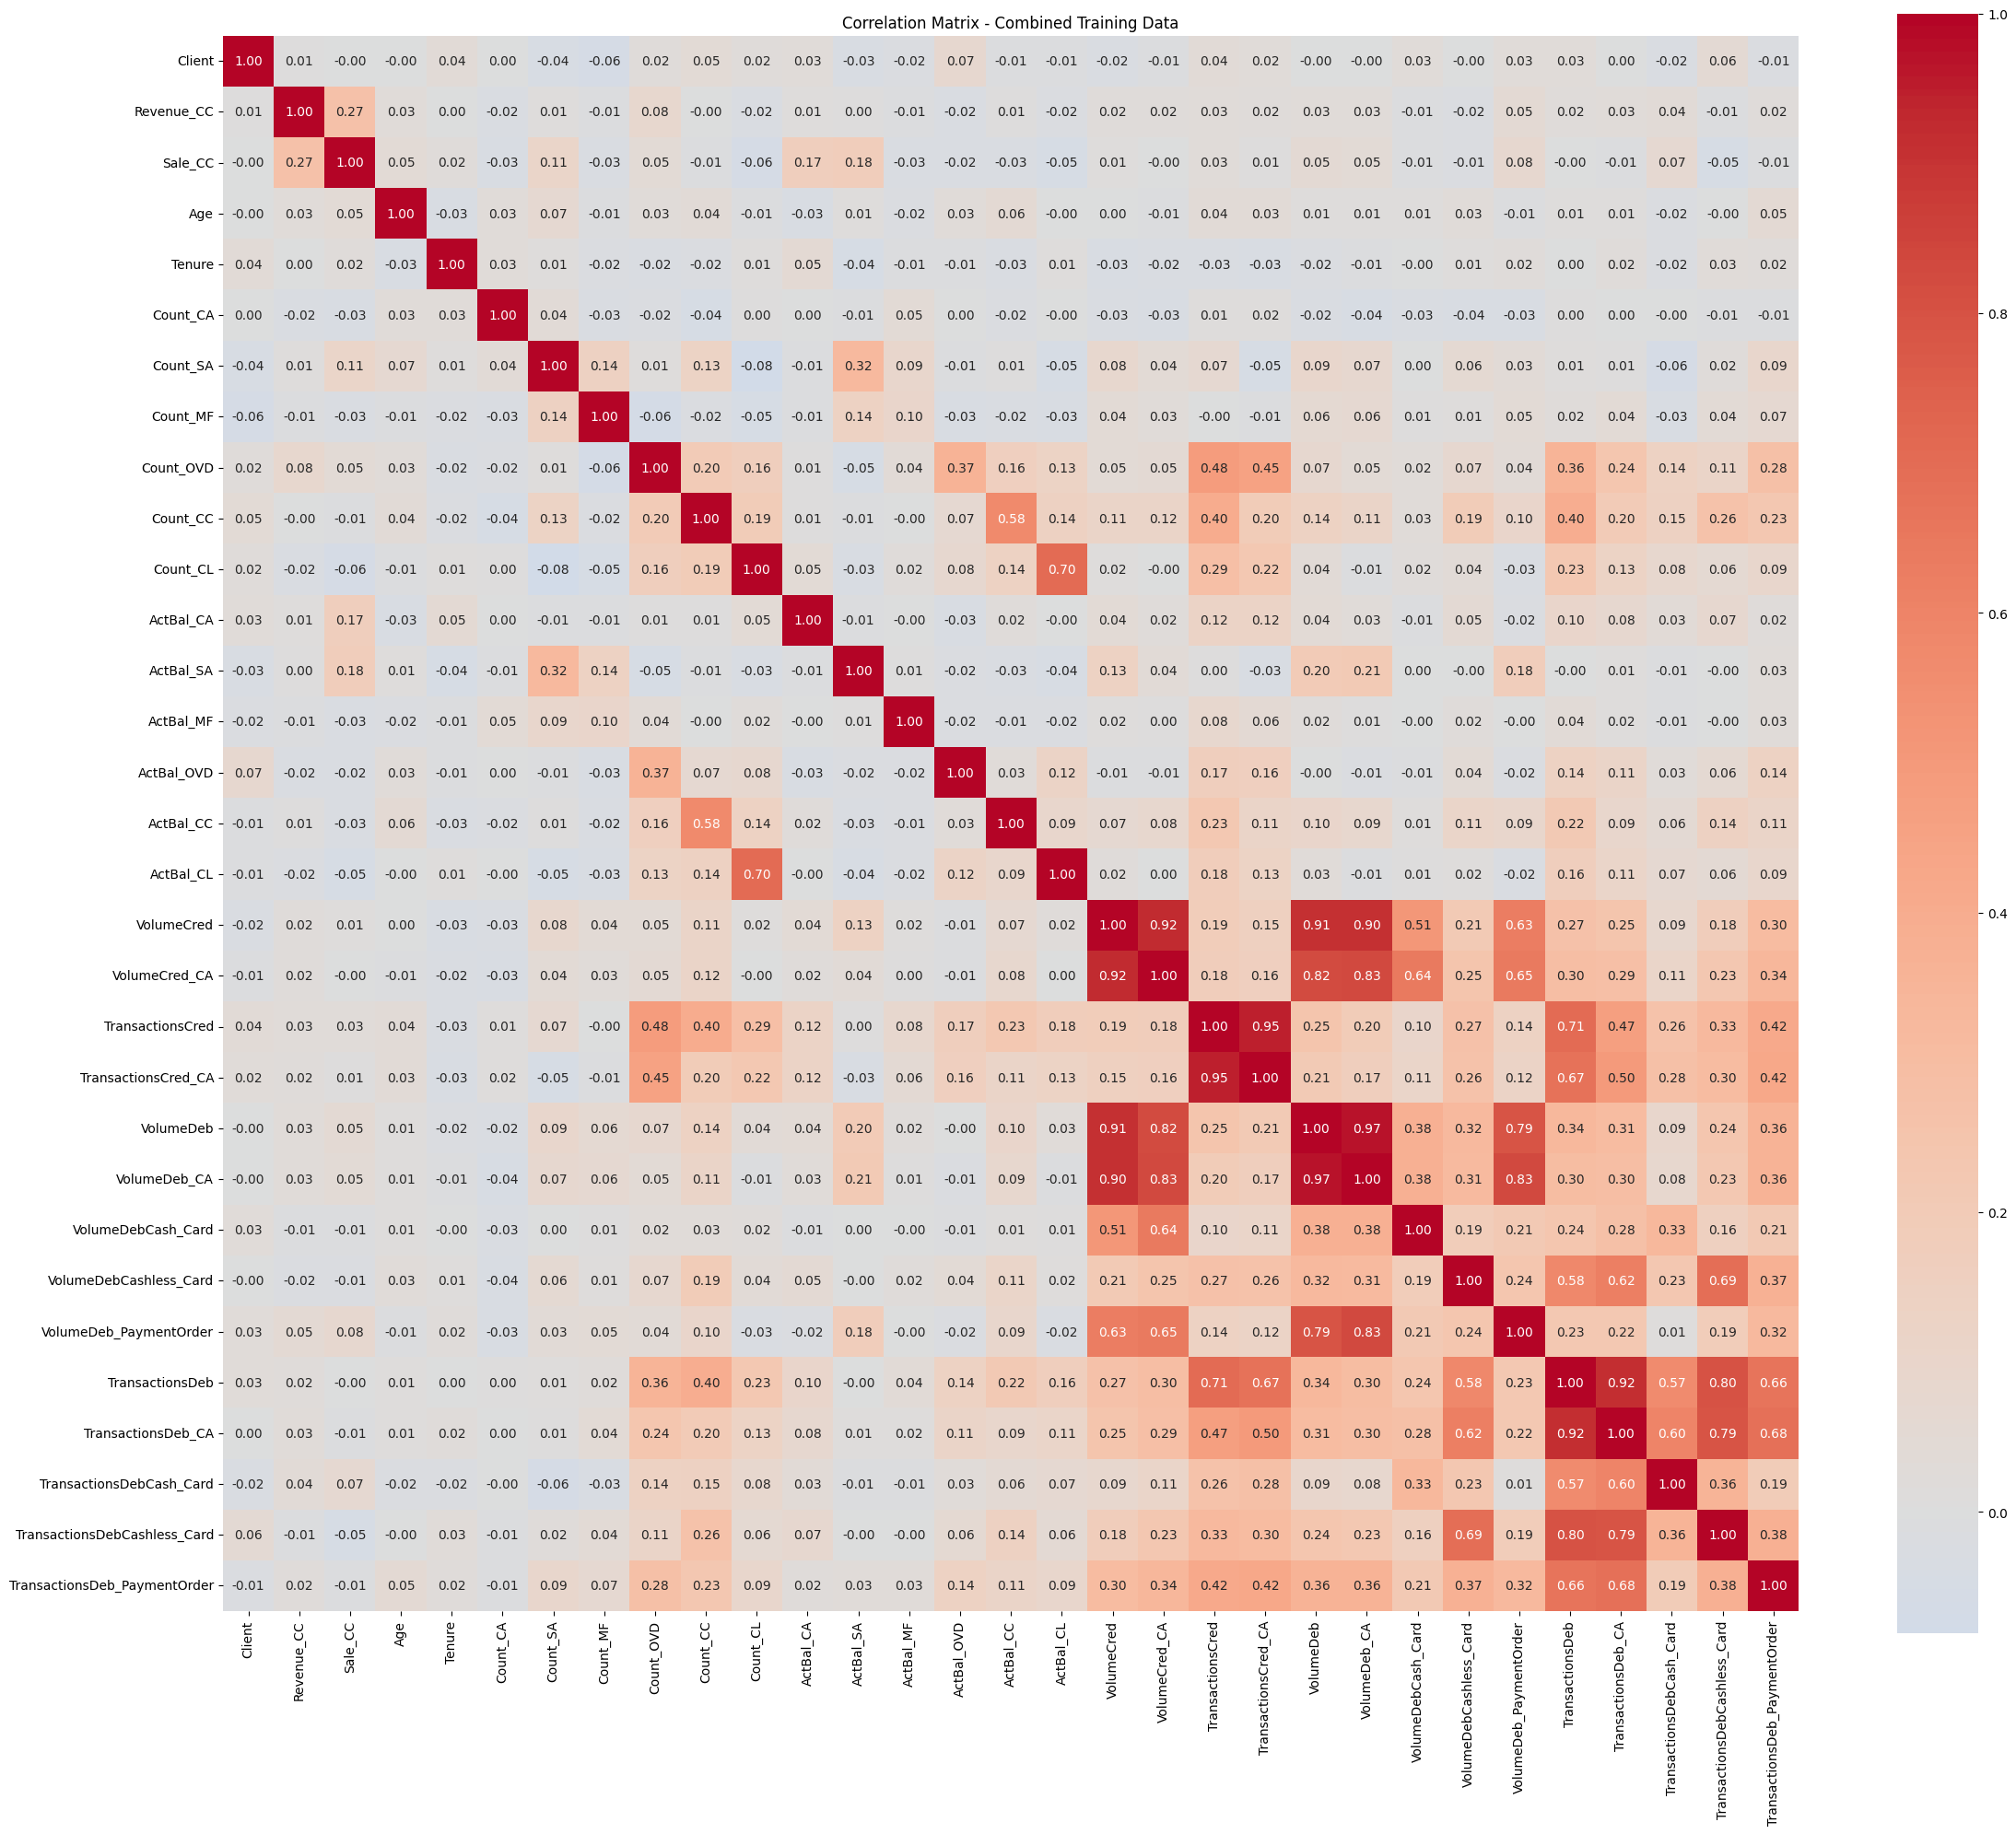

In [34]:
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Get numeric columns only
numeric_data = combined_train_data.select_dtypes(include=[np.number])

# Calculate correlation matrix using scipy
corr_matrix = numeric_data.corr(method="pearson")

# Create correlation plot
plt.figure(figsize=(24, 20))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", center=0, fmt=".2f", square=True)

plt.title("Correlation Matrix - Combined Training Data")
plt.tight_layout()
plt.show()

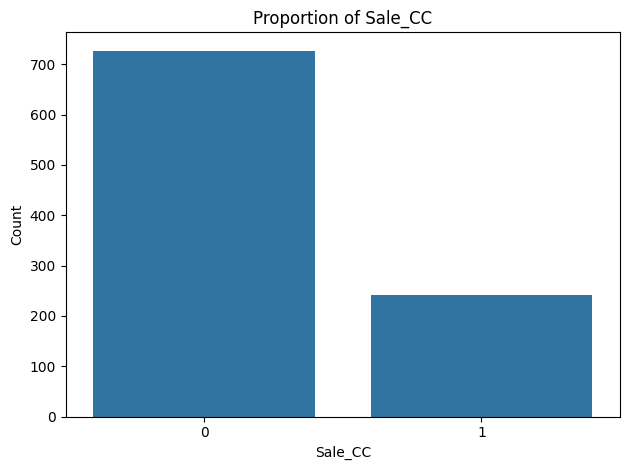

 Sale_CC Proportions: Sale_CC
0    75.0258
1    24.9742
Name: proportion, dtype: float64


In [35]:
# Proportion of Sale_CC
plt.Figure(figsize=(8, 6))
sns.countplot(data=combined_train_data, x="Sale_CC")
plt.title("Proportion of Sale_CC")
plt.xlabel("Sale_CC")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# Percentage
sale_cc_counts = combined_train_data["Sale_CC"].value_counts(normalize=True) * 100
print(f" Sale_CC Proportions: {sale_cc_counts}")

/tmp/ipykernel_3969/1646598059.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Sale_CC', loc='upper right')


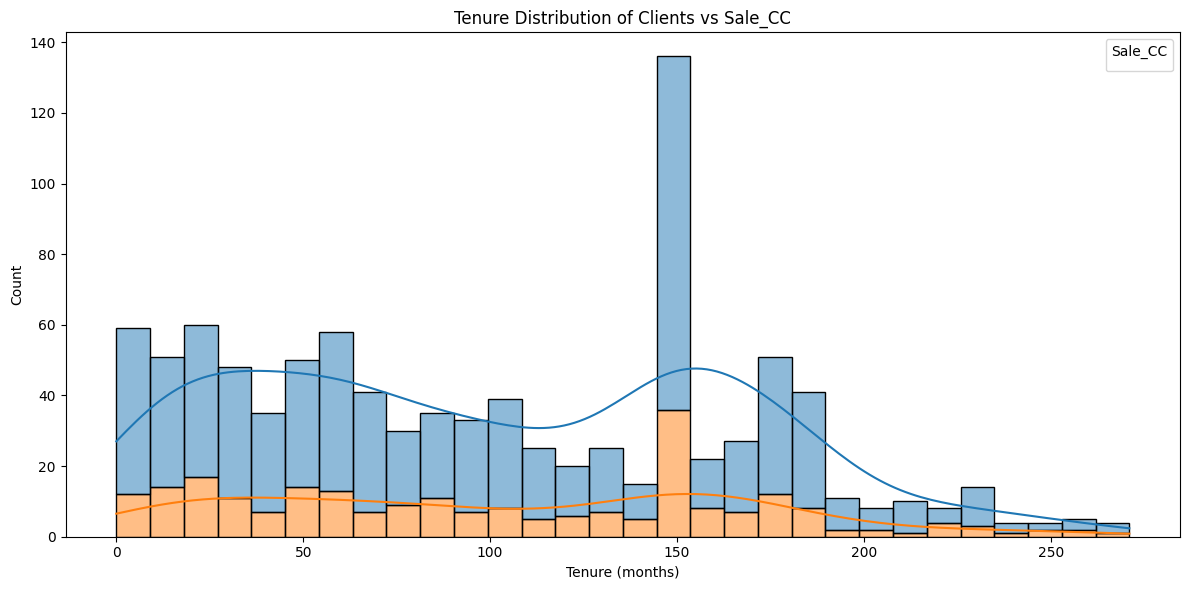

In [36]:
# Tenure Distribution of Clients vs Sale_CC
plt.figure(figsize=(12, 6))
sns.histplot(
    combined_train_data, x="Tenure", hue="Sale_CC", multiple="stack", bins=30, kde=True
)
plt.title("Tenure Distribution of Clients vs Sale_CC")
plt.xlabel("Tenure (months)")
plt.ylabel("Count")
plt.legend(title="Sale_CC", loc="upper right")
plt.tight_layout()
plt.show()

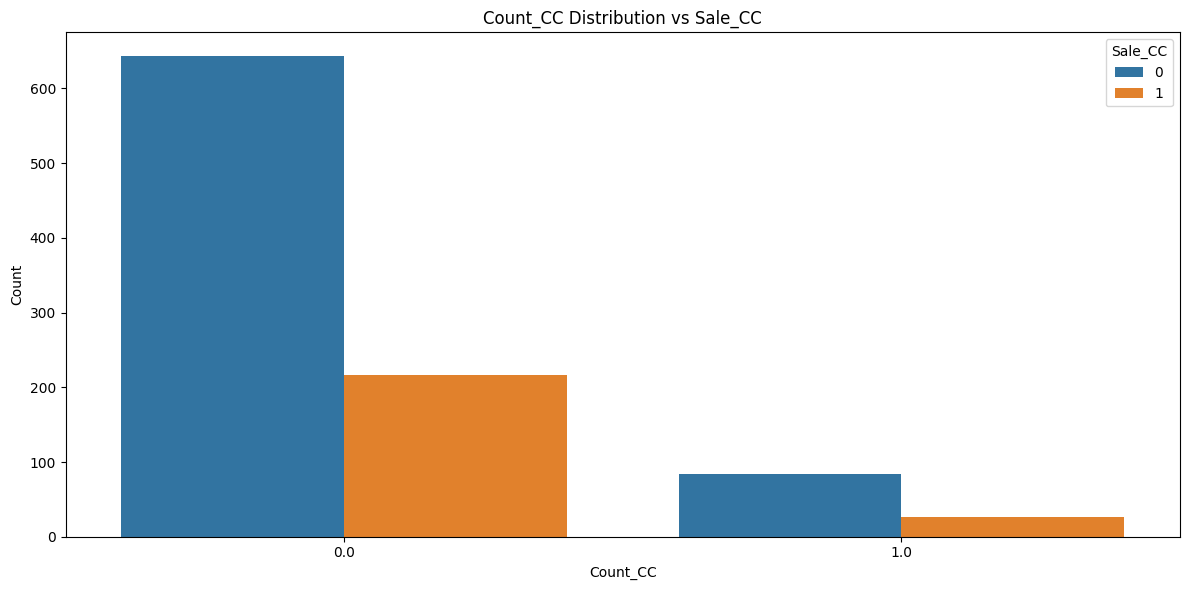

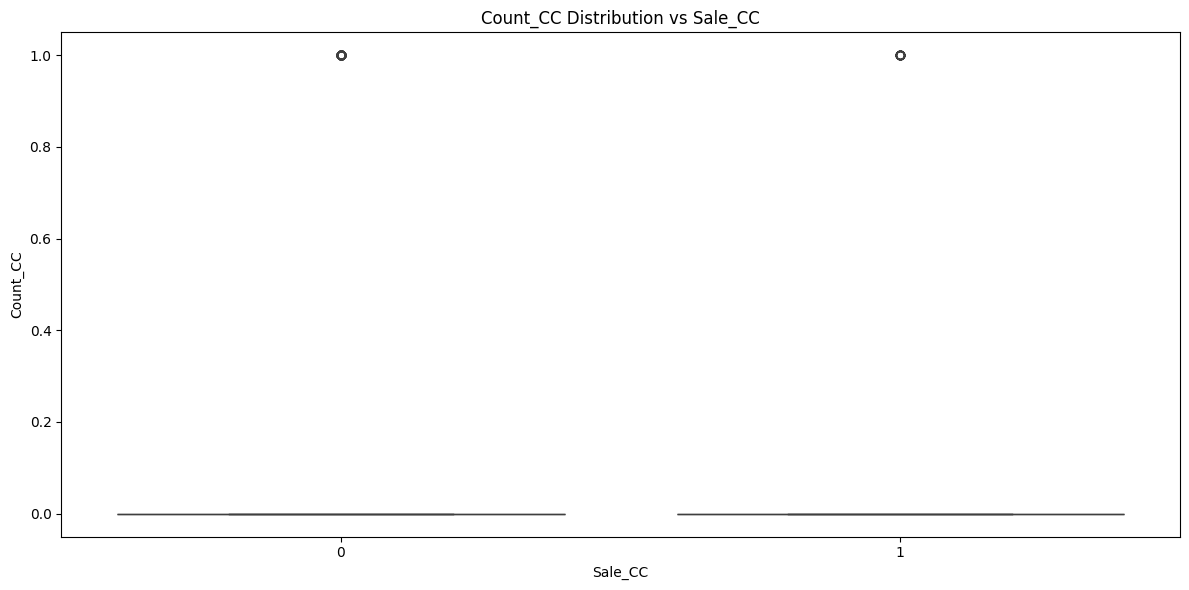

In [37]:
# Count_cc to Sale_CC - Bar plot
plt.figure(figsize=(12, 6))
sns.countplot(data=combined_train_data, x="Count_CC", hue="Sale_CC")
plt.title("Count_CC Distribution vs Sale_CC")
plt.xlabel("Count_CC")
plt.ylabel("Count")
plt.legend(title="Sale_CC")
plt.tight_layout()
plt.show()

# Count_CC to Sale_CC - Box plot
plt.figure(figsize=(12, 6))
sns.boxplot(data=combined_train_data, x="Sale_CC", y="Count_CC")
plt.title("Count_CC Distribution vs Sale_CC")
plt.xlabel("Sale_CC")
plt.ylabel("Count_CC")
plt.tight_layout()
plt.show()

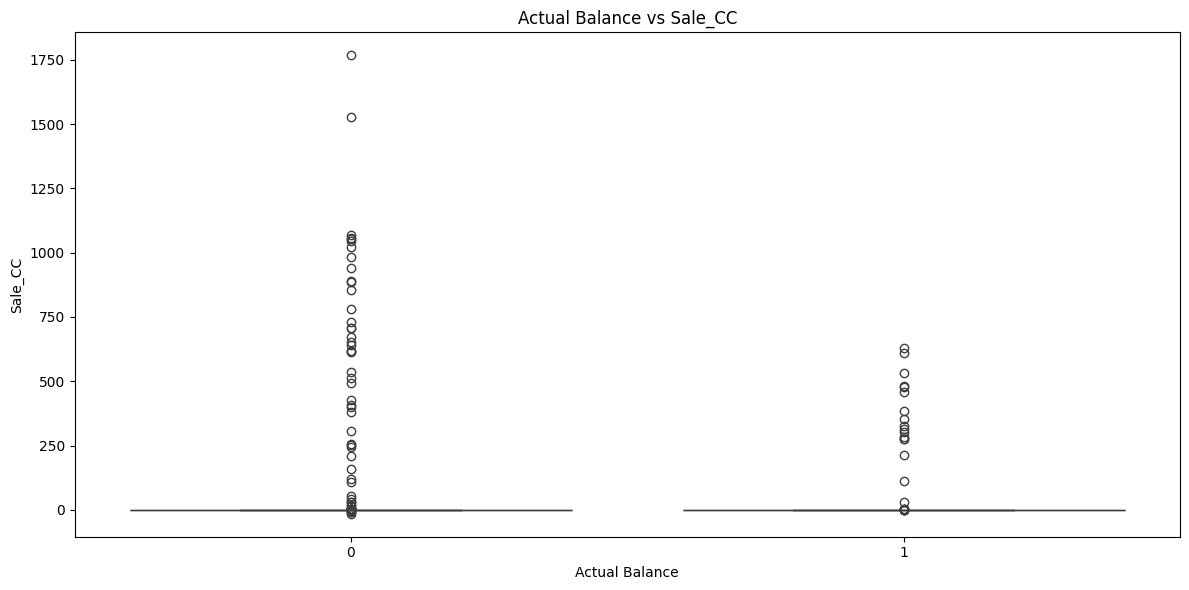

In [38]:
# Actual Balance vs Sale_CC - Box plot
plt.figure(figsize=(12, 6))
sns.boxplot(data=combined_train_data, x="Sale_CC", y="ActBal_CC")
plt.title("Actual Balance vs Sale_CC")
plt.xlabel("Actual Balance")
plt.ylabel("Sale_CC")
plt.tight_layout()
plt.show()

# Predict probabilities of a Sale: 

## Logistic Regression

In [39]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    KFold,
    cross_validate,
)
from sklearn.metrics import roc_auc_score, make_scorer, mean_squared_error, r2_score
import numpy as np

# 1. Define feature lists (same as before)
numeric_features = [
    "Age",
    "Tenure",
    "Count_CA",
    "Count_SA",
    "Count_MF",
    "Count_OVD",
    "Count_CC",
    "Count_CL",
    "ActBal_CA",
    "ActBal_SA",
    "ActBal_MF",
    "ActBal_OVD",
    "ActBal_CC",
    "ActBal_CL",
    "VolumeCred",
    "VolumeCred_CA",
    "TransactionsCred",
    "TransactionsCred_CA",
    "VolumeDeb",
    "VolumeDeb_CA",
    "VolumeDebCash_Card",
    "VolumeDebCashless_Card",
    "VolumeDeb_PaymentOrder",
    "TransactionsDeb",
    "TransactionsDeb_CA",
    "TransactionsDebCash_Card",
    "TransactionsDebCashless_Card",
    "TransactionsDeb_PaymentOrder",
]
categorical_features = ["Sex"]

# 2. Prepare data
X = combined_train_data[numeric_features + categorical_features]
y = combined_train_data["Sale_CC"]

# 3. Create a proper train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Sale_CC positive rate - Train: {y_train.mean():.2%}, Test: {y_test.mean():.2%}")

# 4. Set up the preprocessing and model pipeline (same as before)
numeric_transformer = SimpleImputer(strategy="constant", fill_value=0)
categorical_transformer = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
        ("onehot", OneHotEncoder(handle_unknown="ignore")),
    ]
)
preprocessor = ColumnTransformer(
    [
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)
propensity_pipe = Pipeline(
    [
        ("prep", preprocessor),
        (
            "clf",
            LogisticRegression(
                penalty="l2",
                solver="saga",
                max_iter=5000,
                class_weight="balanced",
                random_state=42,
            ),
        ),
    ]
)
# 5. Cross-validation for propensity model
cv = KFold(n_splits=5, shuffle=True, random_state=42)
scoring = {"auc": make_scorer(roc_auc_score), "accuracy": "accuracy"}
cv_results = cross_validate(
    propensity_pipe, X_train, y_train, cv=cv, scoring=scoring, return_train_score=True
)
# 6. Print cross-validation results
print("\nCross-Validation Results (Propensity Model):")
print(
    f"Train AUC: {np.mean(cv_results['train_auc']):.4f} ± {np.std(cv_results['train_auc']):.4f}"
)
print(
    f"CV AUC: {np.mean(cv_results['test_auc']):.4f} ± {np.std(cv_results['test_auc']):.4f}"
)
print(
    f"Train Accuracy: {np.mean(cv_results['train_accuracy']):.4f} ± {np.std(cv_results['train_accuracy']):.4f}"
)
print(
    f"CV Accuracy: {np.mean(cv_results['test_accuracy']):.4f} ± {np.std(cv_results['test_accuracy']):.4f}"
)

# 7. Final evaluation on test set
propensity_pipe.fit(X_train, y_train)
test_probas = propensity_pipe.predict_proba(X_test)[:, 1]
test_auc = roc_auc_score(y_test, test_probas)
print(f"\nTest Set AUC: {test_auc:.4f}")

Training set: 726 samples
Test set: 243 samples
Sale_CC positive rate - Train: 24.93%, Test: 25.10%


/home/c-hiy/direct-marketing-optimization/.venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



Cross-Validation Results (Propensity Model):
Train AUC: 0.5672 ± 0.0083
CV AUC: 0.5471 ± 0.0277
Train Accuracy: 0.5375 ± 0.0114
CV Accuracy: 0.5193 ± 0.0168

Test Set AUC: 0.6271


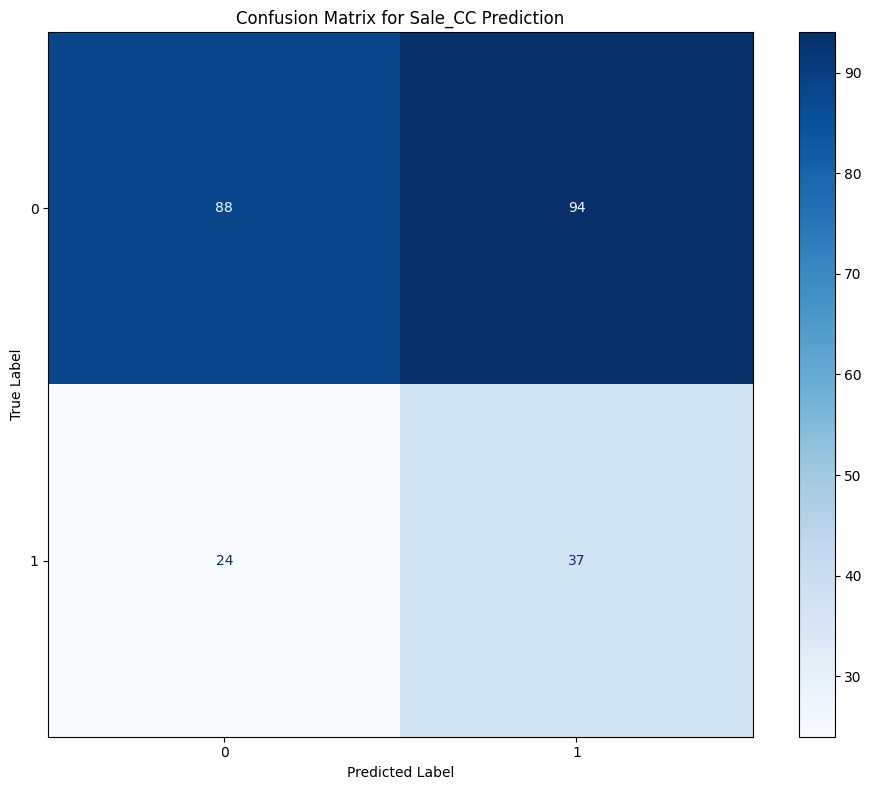

Precision: 0.2824
Recall: 0.6066
F1 Score: 0.3854
Accuracy: 0.5144


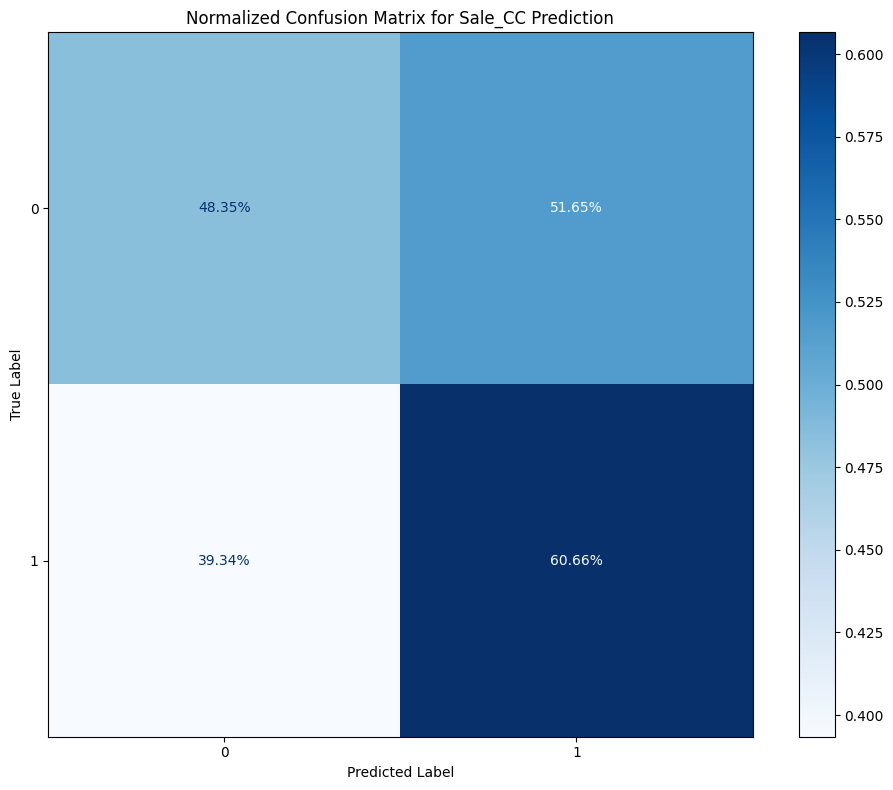

In [40]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Make predictions on the test set
y_pred = propensity_pipe.predict(X_test)

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot non-normalized confusion matrix
fig, ax = plt.subplots(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap="Blues", values_format="d", ax=ax)
plt.title("Confusion Matrix for Sale_CC Prediction")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

# Calculate additional metrics
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Accuracy: {accuracy:.4f}")

# Plot normalized confusion matrix (percentages)
fig, ax = plt.subplots(figsize=(10, 8))
cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
disp = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=[0, 1])
disp.plot(cmap="Blues", values_format=".2%", ax=ax)
plt.title("Normalized Confusion Matrix for Sale_CC Prediction")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

/home/c-hiy/direct-marketing-optimization/.venv/lib/python3.12/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


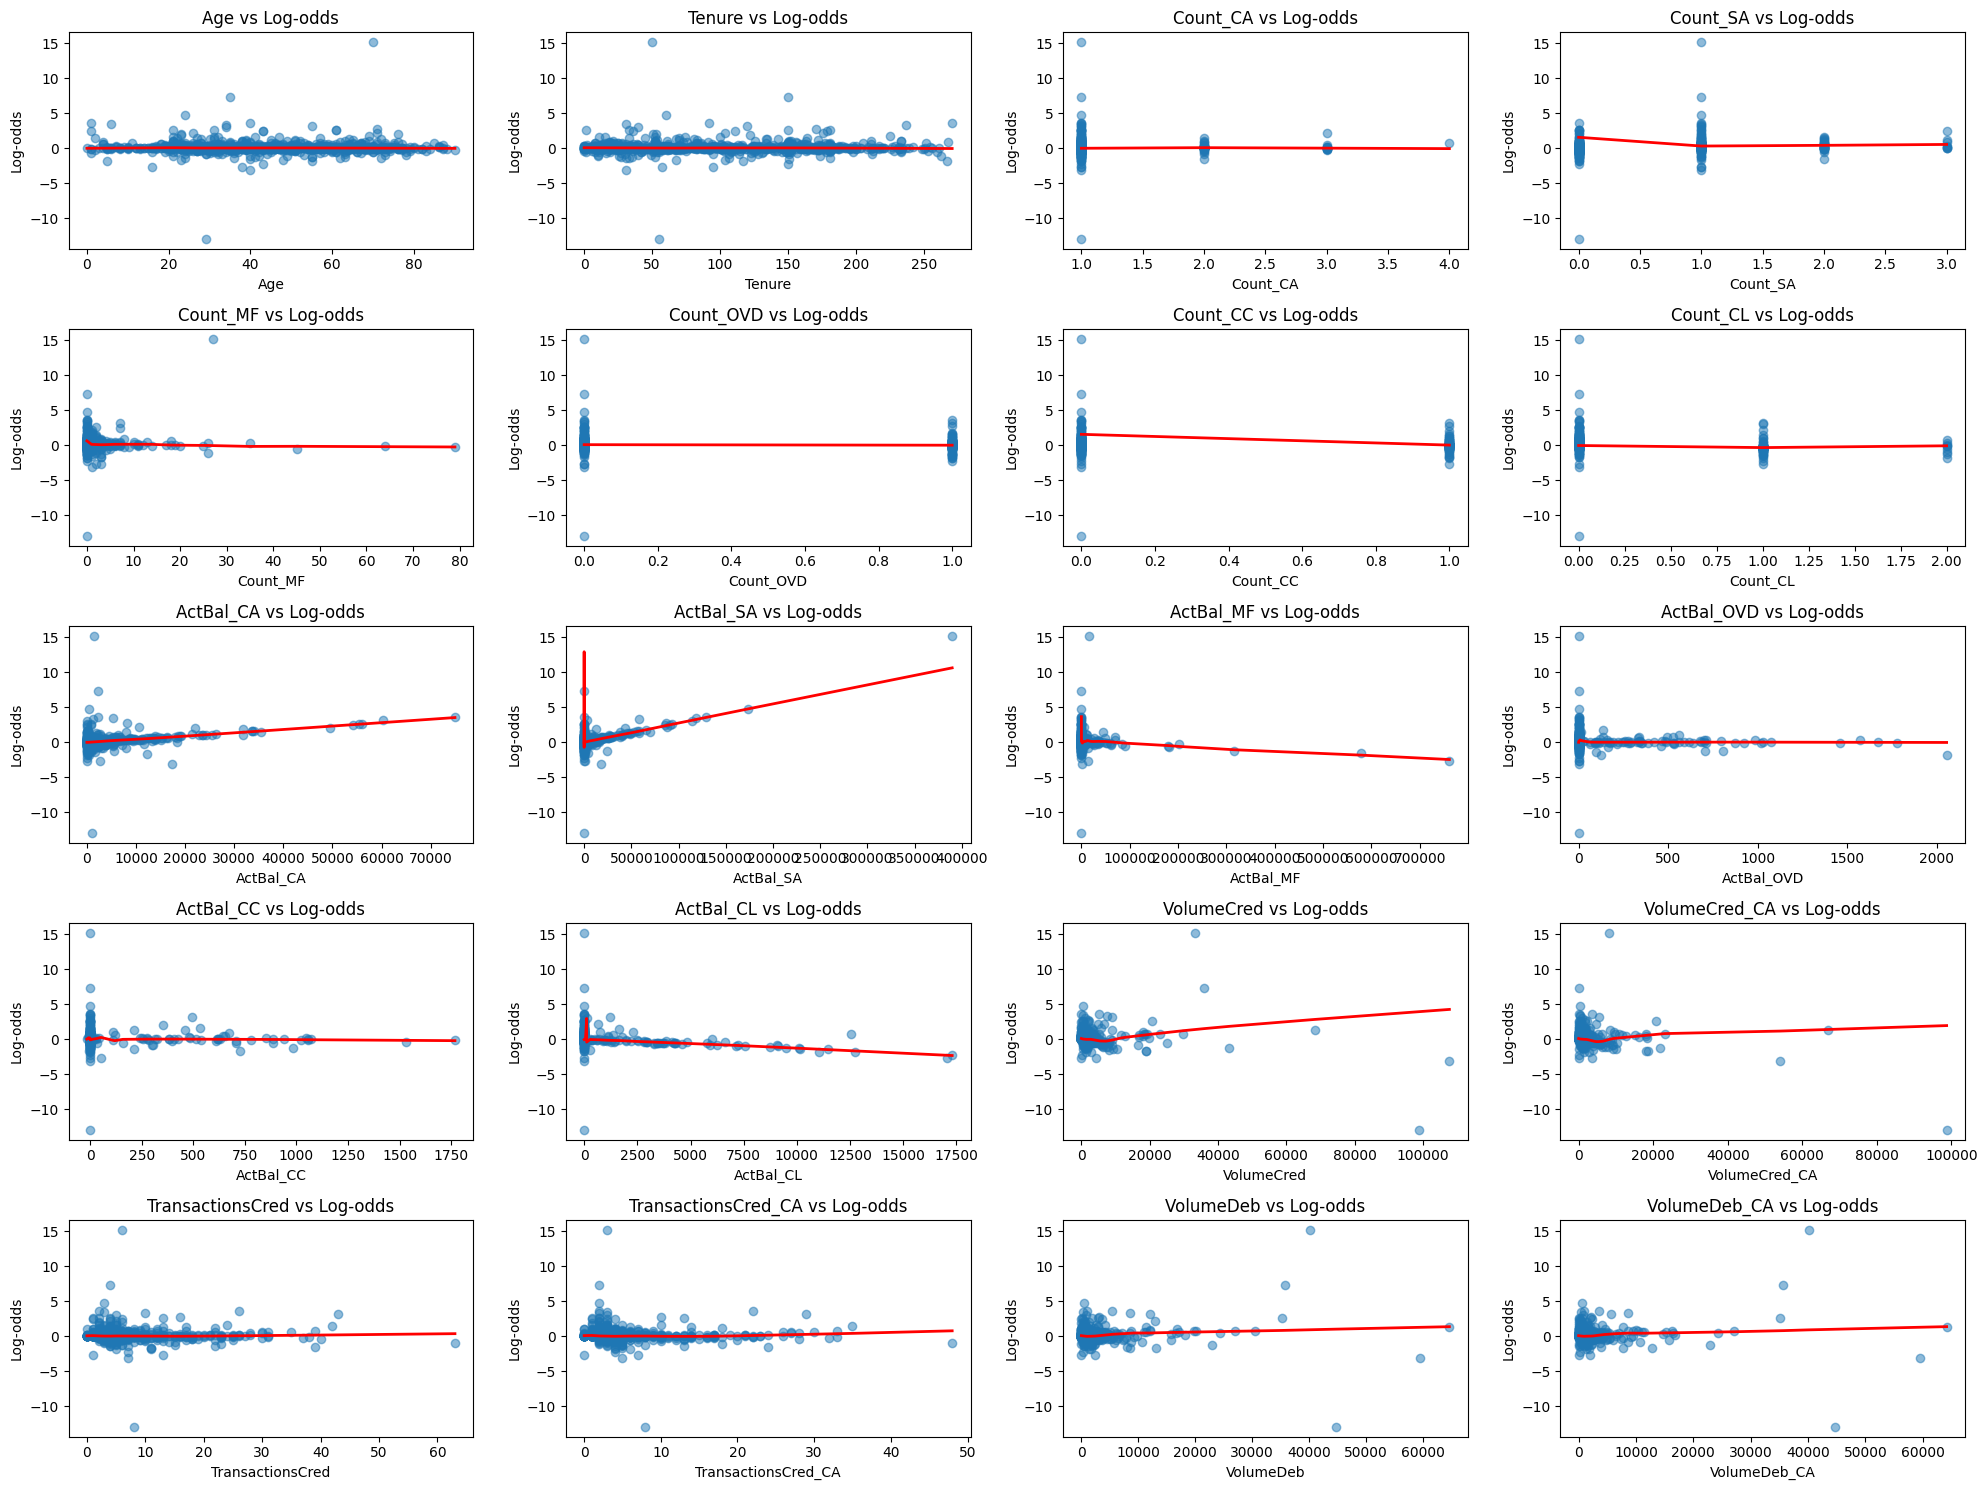

In [41]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from scipy import stats


# 1. Check linearity in the logit
def plot_linearity_check(X, y, feature_names, model):
    """Plot linearity checks for logistic regression"""
    # Get predicted probabilities
    probas = model.predict_proba(X)[:, 1]
    # Calculate logit (log-odds)
    logit = np.log(probas / (1 - probas))
    # Create subplots for selected numeric features
    n_features = min(20, len(feature_names))  # Limit to 20 plots
    fig, axes = plt.subplots(5, 4, figsize=(20, 15))
    axes = axes.flatten()

    for i, feature in enumerate(feature_names[:n_features]):
        feature_idx = (
            list(X.columns).index(feature) if isinstance(X, pd.DataFrame) else i
        )
        feature_values = (
            X.iloc[:, feature_idx] if isinstance(X, pd.DataFrame) else X[:, feature_idx]
        )

        # Plot feature vs logit
        axes[i].scatter(feature_values, logit, alpha=0.5)

        # Add lowess smoother to check for linearity
        lowess = sm.nonparametric.lowess
        z = lowess(logit, feature_values, frac=0.3)
        axes[i].plot(z[:, 0], z[:, 1], color="red", linewidth=2)

        axes[i].set_title(f"{feature} vs Log-odds")
        axes[i].set_xlabel(feature)
        axes[i].set_ylabel("Log-odds")

    plt.tight_layout()
    plt.show()


plot_linearity_check(X, y, numeric_features, propensity_pipe)

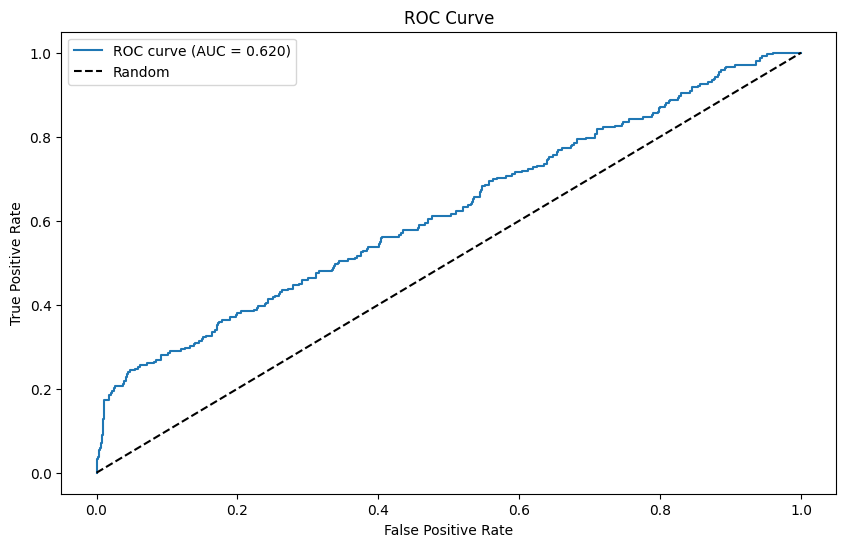

In [42]:
# 4. Model performance check
def plot_roc_curve(X, y, model):
    """Plot ROC curve and show AUC"""
    y_pred_proba = model.predict_proba(X)[:, 1]
    fpr, tpr, thresholds = roc_curve(y, y_pred_proba)
    auc = roc_auc_score(y, y_pred_proba)

    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, label=f"ROC curve (AUC = {auc:.3f})")
    plt.plot([0, 1], [0, 1], "k--", label="Random")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.show()


plot_roc_curve(X, y, propensity_pipe)

In [43]:
# Hosmer-Lemeshow test (for goodness of fit)
def hosmer_lemeshow_test(y_true, y_pred_proba, n_groups=10):
    """Perform Hosmer-Lemeshow test"""
    # Create groups based on predicted probabilities
    quantiles = np.percentile(y_pred_proba, np.linspace(0, 100, n_groups + 1))
    quantiles = np.unique(quantiles)

    observed = np.zeros(len(quantiles) - 1)
    expected = np.zeros(len(quantiles) - 1)
    total = np.zeros(len(quantiles) - 1)

    for i in range(len(quantiles) - 1):
        if i == len(quantiles) - 2:
            # Last bin includes upper bound
            in_bin = (y_pred_proba >= quantiles[i]) & (y_pred_proba <= quantiles[i + 1])
        else:
            in_bin = (y_pred_proba >= quantiles[i]) & (y_pred_proba < quantiles[i + 1])

        observed[i] = np.sum(y_true[in_bin])
        expected[i] = np.sum(y_pred_proba[in_bin])
        total[i] = np.sum(in_bin)

    # Calculate chi-square statistic
    chi_square = np.sum(
        (observed - expected) ** 2 / (expected * (1 - expected / total))
    )
    df = len(quantiles) - 2
    p_value = 1 - stats.chi2.cdf(chi_square, df)

    print(f"Hosmer-Lemeshow test: chi2={chi_square:.3f}, p-value={p_value:.4f}")

    # For Hosmer-Lemeshow test, high p-value indicates good fit
    if p_value < 0.05:
        print("The model fit is poor (p < 0.05)")
    else:
        print("The model fit is adequate (p >= 0.05)")


# Run Hosmer-Lemeshow test
y_pred_proba = propensity_pipe.predict_proba(X)[:, 1]
hosmer_lemeshow_test(y, y_pred_proba)

Hosmer-Lemeshow test: chi2=302.643, p-value=0.0000
The model fit is poor (p < 0.05)


In [44]:
# Feature Importance for Logistic Regression
# Calculate odds ratios
def get_logistic_regression_feature_importance(
    pipe, numeric_features, categorical_features, top_n=20, plot=True, sort_by="abs"
):
    """
    Extract feature importance from a logistic regression pipeline.

    Parameters:
    -----------
    pipe : sklearn.pipeline.Pipeline
        Trained pipeline containing a logistic regression model
    numeric_features : list
        List of numeric feature names
    categorical_features : list
        List of categorical feature names
    top_n : int, default=20
        Number of top features to display
    plot : bool, default=True
        Whether to create a visualization of feature importance
    sort_by : str, default='abs'
        How to sort features: 'abs' (absolute value), 'coef' (raw coefficient), or 'odds' (odds ratio)

    Returns:
    --------
    pandas.DataFrame
        DataFrame with feature importance information
    """
    # Extract logistic regression model from pipeline
    logistic_model = pipe.named_steps["clf"]

    # Extract feature names after preprocessing
    preprocessor = pipe.named_steps["prep"]
    column_trans_names = []

    # Get numeric feature names directly (they're already the feature names, not indices)
    numeric_names = preprocessor.transformers_[0][2]
    column_trans_names.extend(numeric_names)

    # Get feature names for categorical features (one-hot encoded)
    if len(preprocessor.transformers_) > 1 and categorical_features:
        ohe = preprocessor.transformers_[1][1].named_steps["onehot"]
        cat_names = preprocessor.transformers_[1][
            2
        ]  # These are already the feature names
        try:
            ohe_feature_names = ohe.get_feature_names_out(cat_names)
            column_trans_names.extend(ohe_feature_names)
        except:
            # Fallback for older sklearn versions
            for cat in cat_names:
                for category in ohe.categories_[0]:
                    column_trans_names.append(f"{cat}_{category}")

    # Get coefficients and create DataFrame
    coefficients = pd.DataFrame(
        {
            "Feature": column_trans_names,
            "Coefficient": logistic_model.coef_[0],
            "Abs_Coefficient": np.abs(logistic_model.coef_[0]),
        }
    )

    # Calculate odds ratios
    coefficients["Odds_Ratio"] = np.exp(coefficients["Coefficient"])

    # Sort by specified method
    if sort_by == "abs":
        coefficients = coefficients.sort_values("Abs_Coefficient", ascending=False)
    elif sort_by == "coef":
        coefficients = coefficients.sort_values("Coefficient", ascending=False)
    elif sort_by == "odds":
        coefficients = coefficients.sort_values("Odds_Ratio", ascending=False)

    # Keep top N features
    top_coef = coefficients.head(top_n)

    # Print feature importance
    print(f"Top {top_n} features by importance:")
    display(top_coef[["Feature", "Coefficient", "Odds_Ratio"]])

    # Plot feature importance
    if plot:
        plt.figure(figsize=(12, top_n / 2))
        sns.barplot(x="Coefficient", y="Feature", data=top_coef)
        plt.title(f"Top {top_n} Features by Coefficient Value")
        plt.axvline(x=0, color="gray", linestyle="--")
        plt.tight_layout()
        plt.show()

        # Plot odds ratios (log scale)
        plt.figure(figsize=(12, top_n / 2))
        sns.barplot(x="Odds_Ratio", y="Feature", data=top_coef)
        plt.title(f"Top {top_n} Features by Odds Ratio")
        plt.axvline(x=1, color="gray", linestyle="--")
        plt.xscale("log")
        plt.tight_layout()
        plt.show()

    return coefficients

In [45]:
categorical_features

['Sex']

Top 20 features by importance:


,Feature,Coefficient,Odds_Ratio
18,VolumeDeb,1.716813e-04,1.000172
22,VolumeDeb_PaymentOrder,1.389124e-04,1.000139
8,ActBal_CA,4.584572e-05,1.000046
9,ActBal_SA,2.710426e-05,1.000027
14,VolumeCred,1.250530e-05,1.000013
5,Count_OVD,1.511201e-07,1.000000
30,Sex_missing,-1.146952e-08,1.000000
3,Count_SA,-4.556644e-08,1.000000
6,Count_CC,-6.680266e-08,1.000000
7,Count_CL,-8.827825e-08,1.000000


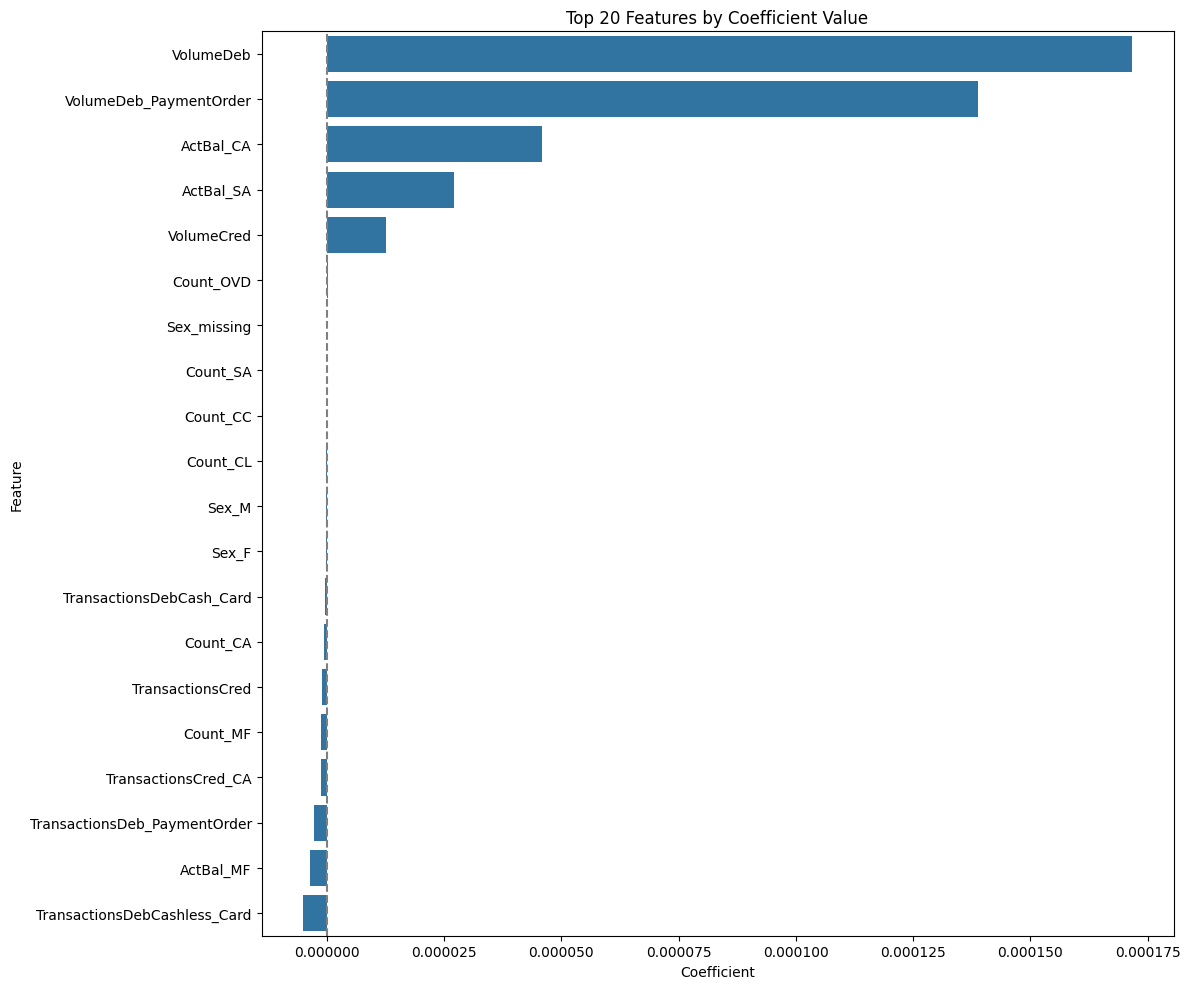

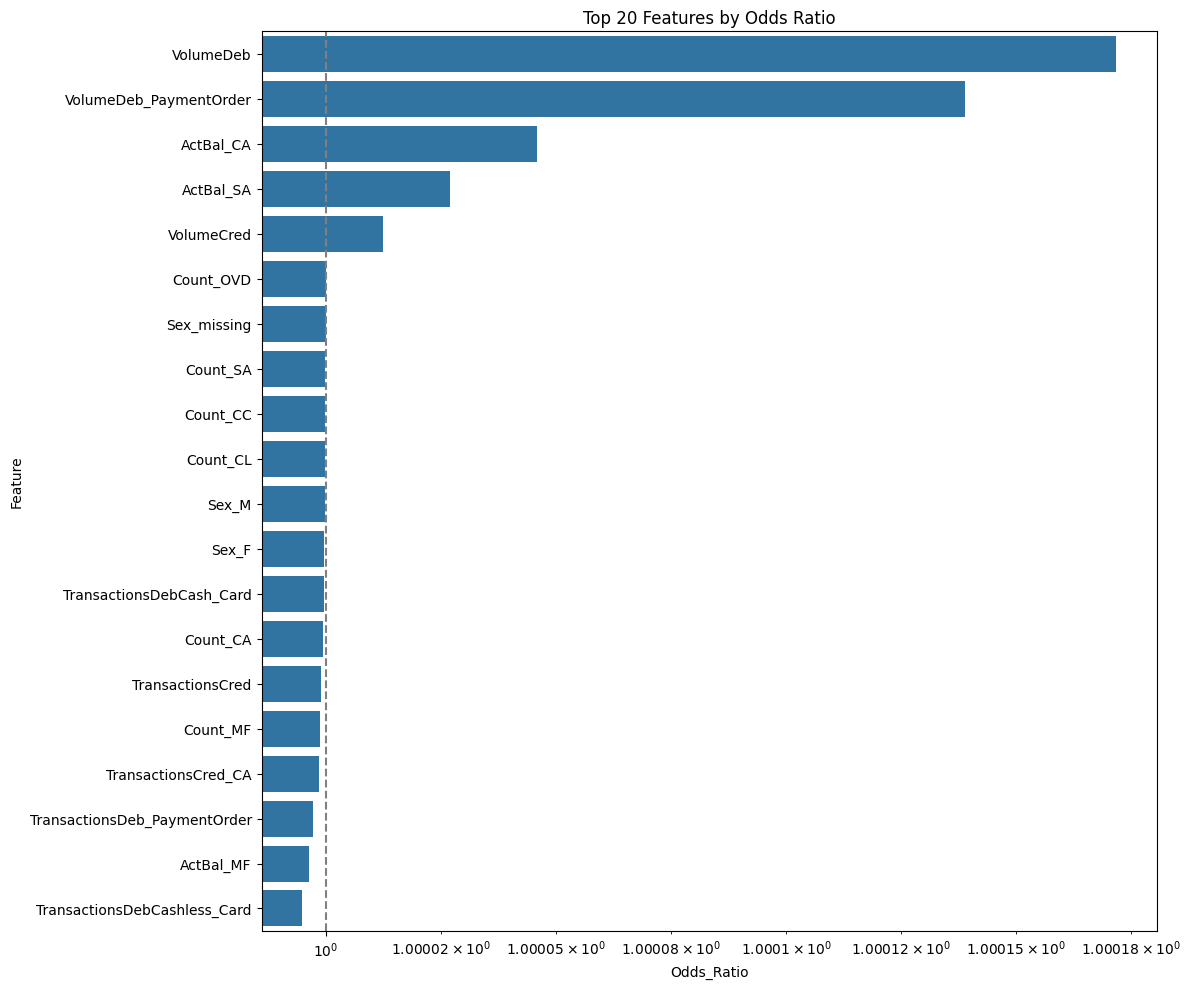

In [46]:
coefficients = get_logistic_regression_feature_importance(
    propensity_pipe,
    numeric_features=numeric_features,
    categorical_features=categorical_features,
    top_n=20,
    plot=True,
    sort_by="odds",
)

# Predict Expected Revenue


# Random Forest Regressor 

In [47]:
# 8. Revenue model with cross-validation
# Filter for only positive cases for revenue model
positive_mask_train = y_train == 1
X_rev_train = X_train[positive_mask_train]
y_rev_train = combined_train_data.loc[X_train.index[positive_mask_train], "Revenue_CC"]

revenue_pipe = Pipeline(
    [
        ("prep", preprocessor),
        ("reg", RandomForestRegressor(n_estimators=100, max_depth=7, random_state=42)),
    ]
)

# 9. Cross-validation for revenue model
rev_scoring = {
    "r2": "r2",
    "mse": make_scorer(mean_squared_error, greater_is_better=False),
}

cv_rev_results = cross_validate(
    revenue_pipe,
    X_rev_train,
    y_rev_train,
    cv=KFold(n_splits=5, shuffle=True, random_state=42),
    scoring=rev_scoring,
    return_train_score=True,
)

print("\nCross-Validation Results (Revenue Model):")
print(
    f"Train R²: {np.mean(cv_rev_results['train_r2']):.4f} ± {np.std(cv_rev_results['train_r2']):.4f}"
)
print(
    f"CV R²: {np.mean(cv_rev_results['test_r2']):.4f} ± {np.std(cv_rev_results['test_r2']):.4f}"
)
print(
    f"Train MSE: {-np.mean(cv_rev_results['train_mse']):.2f} ± {np.std(cv_rev_results['train_mse']):.2f}"
)
print(
    f"CV MSE: {-np.mean(cv_rev_results['test_mse']):.2f} ± {np.std(cv_rev_results['test_mse']):.2f}"
)


Cross-Validation Results (Revenue Model):
Train R²: 0.7960 ± 0.0128
CV R²: -16.9876 ± 18.7907
Train MSE: 254.57 ± 91.73
CV MSE: 1998.82 ± 1687.56


In [48]:
from sklearn.metrics import mean_absolute_error

# 10. Final revenue model evaluation
positive_mask_test = y_test == 1
X_rev_test = X_test[positive_mask_test]
y_rev_test = combined_train_data.loc[X_test.index[positive_mask_test], "Revenue_CC"]

revenue_pipe.fit(X_rev_train, y_rev_train)
y_rev_pred = revenue_pipe.predict(X_rev_test)


# Calculate adjusted R-squared and other model evaluation metrics
def evaluate_regression_model(y_true, y_pred, X, model_name="Model"):
    """
    Comprehensive evaluation of regression model with adjusted R-squared

    Parameters:
    -----------
    y_true : array-like
        Actual target values
    y_pred : array-like
        Predicted target values
    X : DataFrame or array-like
        Feature matrix (needed for adjusted R-squared calculation)
    model_name : str
        Name of the model for display purposes
    """
    n = len(y_true)  # Sample size
    p = X.shape[1]  # Number of predictors

    # Calculate metrics
    r2 = r2_score(y_true, y_pred)
    adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)

    # Print results
    print(f"\n=== {model_name} Evaluation ===")
    print(f"Number of features: {p}")
    print(f"R²: {r2:.4f}")
    print(f"Adjusted R²: {adj_r2:.4f}")
    print(f"MSE: {mse:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}")

    return {"r2": r2, "adj_r2": adj_r2, "mse": mse, "rmse": rmse, "mae": mae}


# Evaluate the revenue model
revenue_metrics = evaluate_regression_model(
    y_rev_test, y_rev_pred, X_rev_test, model_name="Revenue Model"
)


=== Revenue Model Evaluation ===
Number of features: 29
R²: -0.4621
Adjusted R²: -1.8298
MSE: 1289.10
RMSE: 35.90
MAE: 15.46


In [49]:
# Actual vs Predicted Revenue Plot
plt.figure(figsize=(10, 8))
plt.scatter(y_rev_test, test_rev_preds, alpha=0.5)
plt.plot(
    [y_rev_test.min(), y_rev_test.max()], [y_rev_test.min(), y_rev_test.max()], "r--"
)
plt.xlabel("Actual Revenue")
plt.ylabel("Predicted Revenue")
plt.title("Random Forest: Actual vs Predicted Revenue")
plt.tight_layout()
plt.show()

NameError: name 'test_rev_preds' is not defined

<Figure size 1000x800 with 0 Axes>

In [ ]:
# Feature Importance for Revenue Model


def get_random_forest_feature_importance(
    pipe, numeric_features, categorical_features, top_n=20, plot=True
):
    """
    Extract feature importance from a random forest pipeline.

    Parameters:
    -----------
    pipe : sklearn.pipeline.Pipeline
        Trained pipeline containing a random forest model
    numeric_features : list
        List of numeric feature names
    categorical_features : list
        List of categorical feature names
    top_n : int, default=20
        Number of top features to display
    plot : bool, default=True
        Whether to create a visualization of feature importance

    Returns:
    --------
    pandas.DataFrame
        DataFrame with feature importance information
    """
    # Extract random forest model from pipeline
    rf_model = pipe.named_steps["reg"]

    # Extract feature names after preprocessing
    preprocessor = pipe.named_steps["prep"]
    column_trans_names = []

    # Get numeric feature names directly
    numeric_names = preprocessor.transformers_[0][2]
    column_trans_names.extend(numeric_names)

    # Get feature names for categorical features (one-hot encoded)
    if len(preprocessor.transformers_) > 1 and categorical_features:
        ohe = preprocessor.transformers_[1][1].named_steps["onehot"]
        cat_names = preprocessor.transformers_[1][2]
        try:
            ohe_feature_names = ohe.get_feature_names_out(cat_names)
            column_trans_names.extend(ohe_feature_names)
        except:
            # Fallback for older sklearn versions
            for cat in cat_names:
                for category in ohe.categories_[0]:
                    column_trans_names.append(f"{cat}_{category}")

    # Get feature importances and create DataFrame
    importances = pd.DataFrame(
        {"Feature": column_trans_names, "Importance": rf_model.feature_importances_}
    )

    # Sort by importance
    importances = importances.sort_values("Importance", ascending=False)

    # Keep top N features
    top_importances = importances.head(top_n)

    # Print feature importance
    print(f"Top {top_n} features by importance:")
    display(top_importances)

    # Plot feature importance
    if plot:
        plt.figure(figsize=(12, top_n / 2))
        sns.barplot(x="Importance", y="Feature", data=top_importances)
        plt.title(f"Top {top_n} Features by Importance")
        plt.tight_layout()
        plt.show()

    return importances


revenue_importances = get_random_forest_feature_importance(
    revenue_pipe,
    numeric_features=numeric_features,
    categorical_features=categorical_features,
    top_n=20,
    plot=True,
)